# Project description

#### Aim: Use bid data analysis technique to identify are for state assistance for the aging population of maryland

#### Dataset : synthetic health data (https://github.com/synthetichealth/synthea)

## Analysis plan
#### Goal: Identify stroke population,do exploratory analysis, and develop machine learning based stroke prediction model

## Analysis steps
1. Import libraries
2. Import dataset
3. Data cleaning,manipulation, and exploratory and descriptive analysis of aging stroke population
4. Data preprocesing for features extraction
5. Make data ready for spark Mlib
6. Develop models
7. Evaluate classifiers

## 1. Import libraries

In [1]:
#Import required libararies
%config IPCompleter.use_jedi = False
import datetime
import pyspark
import pyspark.mllib.stat as st
import pyspark.ml.feature as ft
import pyspark.sql.types as typ
from pyspark.sql.types import IntegerType
import pyspark.ml.classification as cl
import pyspark.ml.tuning as tune
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report,accuracy_score,confusion_matrix
from sklearn.metrics import auc,roc_auc_score,roc_curve,precision_score,recall_score,f1_score
import time as timer
from sklearn.inspection import permutation_importance
import pandas as pd
import numpy as np
import seaborn as sns
import statsmodels.api as sm
import pprint as pp
from pyspark.ml import Pipeline
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession
%matplotlib inline

spark = SparkSession.builder.getOrCreate()
sc = spark.sparkContext


In [2]:
sc

<SparkContext master=local[*] appName=PySparkShell>

## 2. Import patients, conditions, observation, and procedures csv files

### Convert csv files to panda dataframes

In [3]:
# Read patients.csv file
demo_df=pd.read_csv("./patients.csv")
condition_df=pd.read_csv("./conditions.csv")
encounter_df=pd.read_csv("./encounters.csv")
observation_df=pd.read_csv("./observations.csv")
devices_df=pd.read_csv("./devices.csv")
procedures_df=pd.read_csv("./procedures.csv")

## 3. Data manipulation and data cleaning

### 3.1 "Patients" dataframe process:Keep only alive patients and age more than 65 years 

In [4]:
#Check datatypes and change dateformate
demo_df["BIRTHDATE"]=pd.to_datetime(demo_df["BIRTHDATE"])
demo_df["BIRTHDATE"]=demo_df["BIRTHDATE"]-pd.DateOffset(years=100)
demo_df["DEATHDATE"]=pd.to_datetime(demo_df["DEATHDATE"])
demo_df.head(3)

,Id,BIRTHDATE,DEATHDATE,PREFIX,SUFFIX,MARITAL,RACE,ETHNICITY,GENDER,BIRTHPLACE,CITY,STATE,COUNTY,HEALTHCARE_EXPENSES,HEALTHCARE_COVERAGE
0,f1639046-ecb1-b409-21d3-85a7e8e23c81,1957-08-31,NaT,Ms.,NaN,S,white,nonhispanic,F,Germantown Maryland US,Baltimore,Maryland,Baltimore city,59484.51,1455.08
1,f851859f-b0fe-8b36-9939-4276b96d302d,1950-11-22,NaT,Mrs.,NaN,M,black,nonhispanic,F,Clarksburg Maryland US,Baltimore,Maryland,Baltimore city,239428.05,12764.06
2,00e22b7e-70ae-e926-e0f6-4f3d8e30d019,1953-10-24,2019-07-12,Mr.,NaN,S,black,nonhispanic,M,Oxon Hill Maryland US,Downsville,Maryland,Washington County,1345863.62,3951.81


In [5]:
#Drop dead patients and drop columns deathdate, prefix, suffix, state
demo_df_alive=demo_df[demo_df["DEATHDATE"].isnull()]
demo_df_alive=demo_df_alive.drop(columns=["DEATHDATE","PREFIX","SUFFIX"])
demo_df_alive.count()

Id                     25000
BIRTHDATE              25000
MARITAL                25000
RACE                   25000
ETHNICITY              25000
GENDER                 25000
BIRTHPLACE             25000
CITY                   25000
STATE                  25000
COUNTY                 25000
HEALTHCARE_EXPENSES    25000
HEALTHCARE_COVERAGE    25000
dtype: int64

In [ ]:
#Calculate age using lambda function
demo_df_alive["AGE"]=demo_df_alive["BIRTHDATE"].apply(lambda x: (pd.datetime.now().year-x.year))

#Keep people with year >60
demo_aging=demo_df_alive[demo_df_alive["AGE"]>65]

In [7]:
#Rename ID column with patient column for future use
demo_aging=demo_aging.rename(columns={"Id":"PATIENT"})
demo_aging.set_index("PATIENT")

#Patient demographic dataframe with age>65
demo_aging.head(1)

,PATIENT,BIRTHDATE,MARITAL,RACE,ETHNICITY,GENDER,BIRTHPLACE,CITY,STATE,COUNTY,HEALTHCARE_EXPENSES,HEALTHCARE_COVERAGE,AGE
1,f851859f-b0fe-8b36-9939-4276b96d302d,1950-11-22,M,black,nonhispanic,F,Clarksburg Maryland US,Baltimore,Maryland,Baltimore city,239428.05,12764.06,71


### 3.2 "Condition" dataframe process:create dataframe with stroke risk factors featuers and keep it for patient above 65 years old 

#### A.Identify top 25 condtions in older alive patients and develop bar charts

In [8]:
#Merge condition and demo aging dataframes
merged_cond_demo=pd.merge(demo_aging,condition_df,on="PATIENT",how="left")

# Group by conditions and count patients
cond_demo_groupby=merged_cond_demo.groupby('DESCRIPTION')['PATIENT'].nunique().sort_values(ascending=False)

#conver series into dataframe
cond_demo_grp_df=pd.DataFrame(cond_demo_groupby).reset_index()

#Keep top 25 most condition in older people
most_condition=cond_demo_grp_df.loc[0:24]
most_condition.head(25)

,DESCRIPTION,PATIENT
0,Suspected COVID-19,16567
1,COVID-19,16167
2,Fever (finding),14731
3,Viral sinusitis (disorder),12929
4,Body mass index 30+ - obesity (finding),11928
5,Cough (finding),11221
6,Prediabetes,10387
7,Anemia (disorder),9095
8,Acute viral pharyngitis (disorder),8773
9,Loss of taste (finding),8426


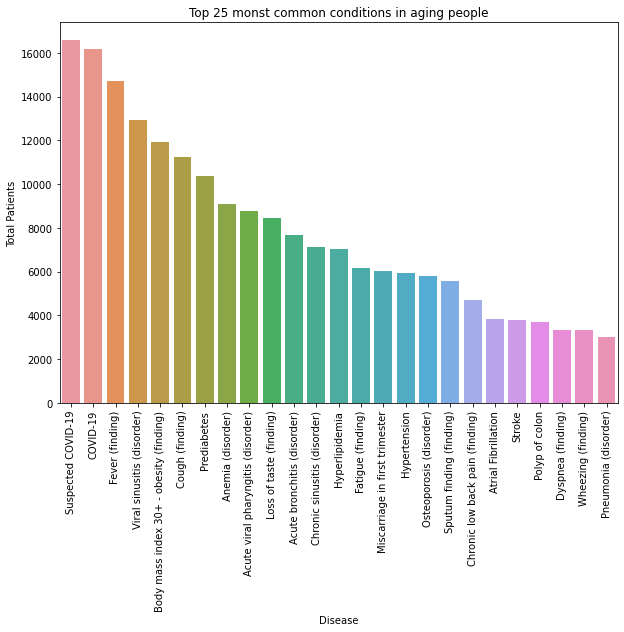

In [9]:
#Create bar plot for most common condition in older people
#Create bar plot with seaborn
plt.figure(figsize=(10,7))
conditions_bar=sns.barplot(x='DESCRIPTION', y='PATIENT',data=most_condition,ci=95)
plt.xticks(rotation=90)

#change the title, x-axis and y-axis
conditions_bar.set(title='Top 25 monst common conditions in aging people', xlabel='Disease',ylabel='Total Patients')

#show the barplot
plt.show()
plt.ioff()

### B.Top conditions by gender in aging population

In [10]:
#Group by gender
gender_cond=cond_demo_groupby=merged_cond_demo.groupby(['DESCRIPTION',"GENDER"])["PATIENT"].nunique().sort_values(ascending=False)
#conver series into dataframe
gender_cond_df=pd.DataFrame(gender_cond).reset_index()

#Seperate dataframe by gender

male_cond=gender_cond_df[gender_cond_df["GENDER"]=="M"]
male_cond.reset_index(drop=True,inplace=True)
female_cond=gender_cond_df[gender_cond_df["GENDER"]=="F"]
female_cond.reset_index(drop=True,inplace=True)


#Keep top 30 most condition in older people by gender
female_most_cond=female_cond.loc[0:29]
male_most_cond=male_cond.loc[0:29]
male_most_cond.shape

(30, 3)

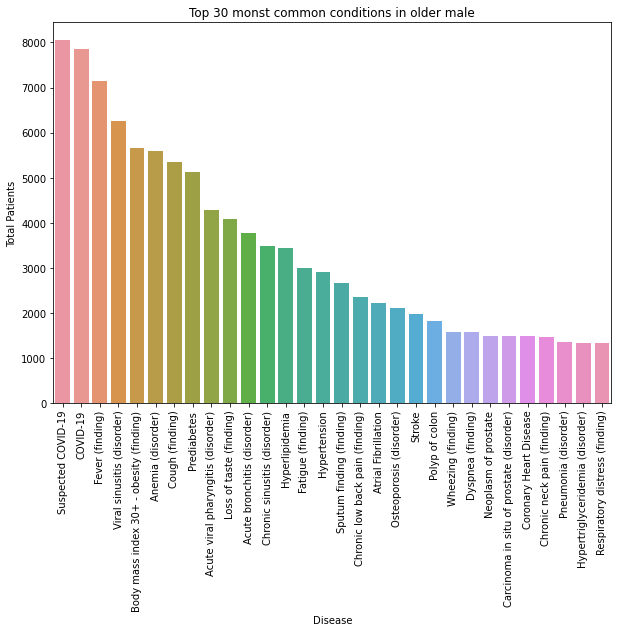

In [11]:
#Create bar plot for most common condition in older people
#Create bar plot with seaborn
plt.figure(figsize=(10,7))
male_conditions_bar=sns.barplot(x='DESCRIPTION', y='PATIENT',data=male_most_cond,ci=95)
plt.xticks(rotation=90)

#change the title, x-axis and y-axis
male_conditions_bar.set(title='Top 30 monst common conditions in older male', xlabel='Disease',ylabel='Total Patients')

#show the barplot
plt.show()
plt.ioff()

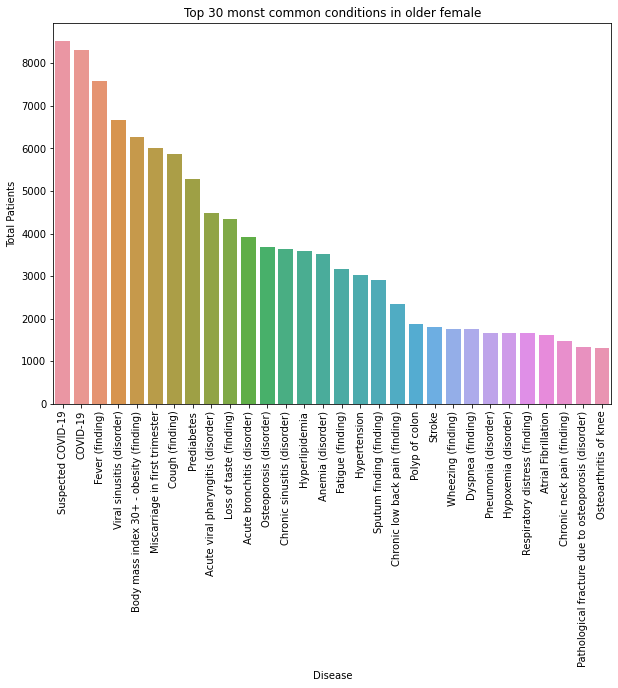

In [12]:
#Create bar plot for most common condition in older people
#Create bar plot with seaborn
plt.figure(figsize=(10,7))
female_conditions_bar=sns.barplot(x='DESCRIPTION', y='PATIENT',data=female_most_cond,ci=95)
plt.xticks(rotation=90)

#change the title, x-axis and y-axis
female_conditions_bar.set(title='Top 30 monst common conditions in older female', xlabel='Disease',ylabel='Total Patients')

#show the barplot
plt.show()
plt.ioff()

### B. Stroke distribution by gender, race, and other demographic factors

#### By age

In [13]:
#Create stroke only dataframe 
stroke_df=merged_cond_demo[merged_cond_demo["DESCRIPTION"]=="Stroke"]

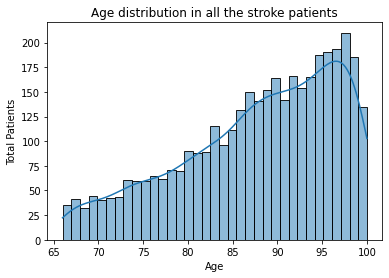

In [14]:
#Older age distribution among the stroke patients
stroke_age_histo=sns.histplot(data=stroke_df, x="AGE",kde=True,bins=35)
stroke_age_histo.set(title='Age distribution in all the stroke patients', xlabel='Age',ylabel='Total Patients')
plt.show()
plt.ioff()

#### By gender

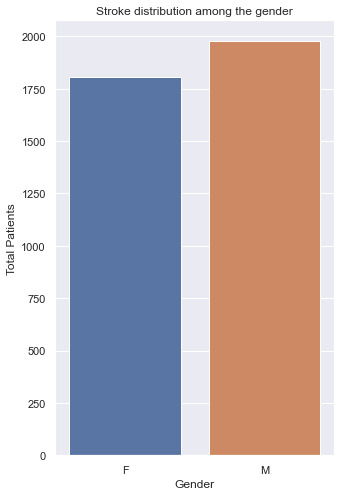

In [15]:
#Stroke distribution among gender
plt.figure(figsize=(5,8))
sns.set_theme(style="darkgrid")
gender_stroke_bar=sns.countplot(x="GENDER",data=stroke_df)
gender_stroke_bar.set(title='Stroke distribution among the gender', xlabel='Gender',ylabel='Total Patients')

plt.show()
plt.ioff()

### By race

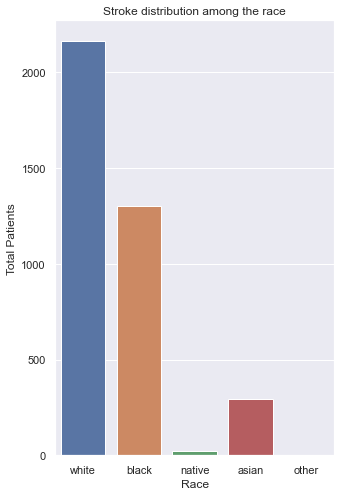

In [16]:
#Stroke distribution among the race
plt.figure(figsize=(5,8))
sns.set_theme(style="darkgrid")
race_stroke_bar=sns.countplot(x="RACE",data=stroke_df)
race_stroke_bar.set(title='Stroke distribution among the race', xlabel='Race',ylabel='Total Patients')
plt.show()
plt.ioff()

#### By ethnicity

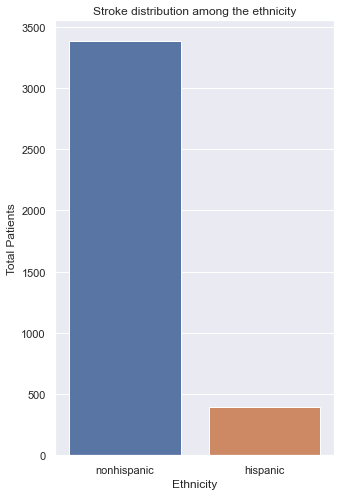

In [17]:
##Stroke distribution among the ethnicity
plt.figure(figsize=(5,8))
sns.set_theme(style="darkgrid")
ethnicity_stroke_bar=sns.countplot(x="ETHNICITY",data=stroke_df)
ethnicity_stroke_bar.set(title='Stroke distribution among the ethnicity', xlabel='Ethnicity',ylabel='Total Patients')
plt.show()
plt.ioff()

#### By counties of maryland

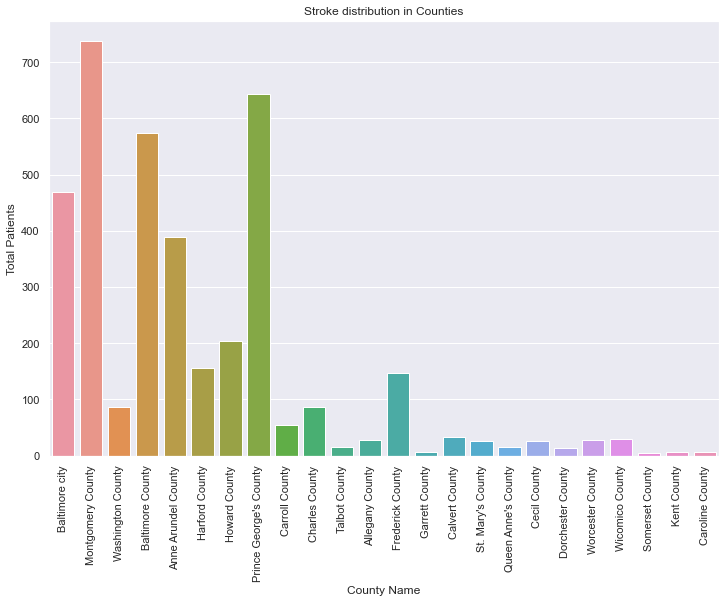

In [18]:
##Stroke distribution by County
plt.figure(figsize=(12,8))
sns.set_theme(style="darkgrid")
county_stroke_bar=sns.countplot(x="COUNTY",data=stroke_df)
county_stroke_bar.set(title='Stroke distribution in Counties', xlabel='County Name',ylabel='Total Patients')
plt.xticks(rotation=90)
plt.show()
plt.ioff()

### 4. Extract stroke risk factors features

#### A. Stroke risk factors features from "Condition" dataframe

##### Atrial fibrillation, Diabetes, Heart failure, Hypertension, Hyperlipidemia, Metabolic syndrome, Stroke, Smoking status features extraction

In [19]:
#Locate stroke risk factors features in condition dataframe
AFib_df=condition_df.loc[condition_df["DESCRIPTION"]=="Atrial Fibrillation"].drop(["STOP","START","ENCOUNTER","CODE"],axis=1).set_index("PATIENT")
DM_df=condition_df.loc[condition_df["DESCRIPTION"]=="Diabetes"].drop(["STOP","START","ENCOUNTER","CODE"],axis=1).set_index("PATIENT")
CHF_df=condition_df.loc[condition_df["DESCRIPTION"]=="Heart failure (disorder)"].drop(["STOP","START","ENCOUNTER","CODE"],axis=1).set_index("PATIENT")
HT_df=condition_df.loc[condition_df["DESCRIPTION"]=="Hypertension"].drop(["STOP","START","ENCOUNTER","CODE"],axis=1).set_index("PATIENT")
HLD_df=condition_df.loc[condition_df["DESCRIPTION"]=="Hyperlipidemia"].drop(["STOP","START","ENCOUNTER","CODE"],axis=1).set_index("PATIENT")
MetSyn_df=condition_df.loc[condition_df["DESCRIPTION"]=="Metabolic syndrome X (disorder)"].drop(["STOP","START","ENCOUNTER","CODE"],axis=1).set_index("PATIENT")
MI_df=condition_df.loc[condition_df["DESCRIPTION"]=="Myocardial Infarction"].drop(["STOP","START","ENCOUNTER","CODE"],axis=1).set_index("PATIENT")
Stroke_df=condition_df.loc[condition_df["DESCRIPTION"]=="Stroke"].drop(["STOP","START","ENCOUNTER","CODE"],axis=1).set_index("PATIENT")
Smoking_df=condition_df.loc[condition_df["DESCRIPTION"]=="Smokes tobacco daily"].drop(["STOP","START","ENCOUNTER","CODE"],axis=1).set_index("PATIENT")

In [20]:
#Rename column names and replace column value with "1"
AFib_df=AFib_df.rename(columns={"DESCRIPTION":"AF"})
DM_df=DM_df.rename(columns={"DESCRIPTION":"DM"})
CHF_df=CHF_df.rename(columns={"DESCRIPTION":"CHF"})
HT_df=HT_df.rename(columns={"DESCRIPTION":"HTN"})
HLD_df=HLD_df.rename(columns={"DESCRIPTION":"HLD"})
MetSyn_df=MetSyn_df.rename(columns={"DESCRIPTION":"METSYN"})
MI_df=MI_df.rename(columns={"DESCRIPTION":"MI"})
Stroke_df=Stroke_df.rename(columns={"DESCRIPTION":"STROKE"})
Smoking_df=Smoking_df.rename(columns={"DESCRIPTION":"SMOKING"})

#Replace column values 
Afib=AFib_df["AF"].replace(["Atrial Fibrillation"],"Yes")
DM=DM_df["DM"].replace(["Diabetes"],"Yes")
CHF=CHF_df["CHF"].replace(["Heart failure (disorder)"],"Yes")
HTN=HT_df["HTN"].replace(["Hypertension"],"Yes")
HLD=HLD_df["HLD"].replace(["Hyperlipidemia"],"Yes")
MetSyn=MetSyn_df["METSYN"].replace(["Metabolic syndrome X (disorder)"],"Yes")
MI=MI_df["MI"].replace(["Myocardial Infarction"],"Yes")
Stroke=Stroke_df["STROKE"].replace(["Stroke"],"Yes")
Smoking=Smoking_df["SMOKING"].replace(["Smokes tobacco daily"],"Yes")

In [21]:
#Merged condtions and demographic dataframes
m_1=pd.merge(demo_aging,Afib, on="PATIENT",how="left").reset_index()
m_2=pd.merge(m_1,DM, on="PATIENT",how="left")
m_3=pd.merge(m_2,CHF, on="PATIENT",how="left")
m_4=pd.merge(m_3,HTN, on="PATIENT",how="left")
m_5=pd.merge(m_4,HLD, on="PATIENT",how="left")
m_6=pd.merge(m_5,MetSyn, on="PATIENT",how="left")
m_7=pd.merge(m_6,MI, on="PATIENT",how="left")
m_8=pd.merge(m_7,Stroke, on="PATIENT",how="left")
DemoCond_DF=pd.merge(m_8,Smoking, on="PATIENT",how="left")

In [22]:
#Demographic and Condition merged dataframe
Demo_Condition_df=DemoCond_DF.drop(columns="index")
Demo_Condition_df.count()

PATIENT                19331
BIRTHDATE              19331
MARITAL                19331
RACE                   19331
ETHNICITY              19331
GENDER                 19331
BIRTHPLACE             19331
CITY                   19331
STATE                  19331
COUNTY                 19331
HEALTHCARE_EXPENSES    19331
HEALTHCARE_COVERAGE    19331
AGE                    19331
AF                      3815
DM                      2496
CHF                       37
HTN                     5923
HLD                     7039
METSYN                  2508
MI                       172
STROKE                  3781
SMOKING                  437
dtype: int64

In [23]:
Demo_Condition_df.shape

(19331, 22)

#### B. Stroke risk factors features from  "Observation". Extract stroke risk factors features BMI, glucose, and systolic blood pressure values

##### BMI Extraction

In [24]:
#Located BMI and create dataframe
bmi_df=observation_df.loc[observation_df["DESCRIPTION"]=="Body Mass Index"]

#Drop columns
bmi_df1=bmi_df[["PATIENT","VALUE"]]
bmi_df1.reset_index(drop=True,inplace=True)

#Convert value to float value
pd.to_numeric(bmi_df1["VALUE"])

#Drop duplicates
bmi_df2=bmi_df1.drop_duplicates()
#Conver value to float value
bmi_df2=bmi_df2.astype({"VALUE": "float64"})

#Calcuate mean
bmi_df3=bmi_df2.groupby("PATIENT").mean()

In [25]:
bmi_df3.shape

(52804, 1)

##### Glucose extraction

In [26]:
#Located Glucose and create dataframe
glucose_df=observation_df.loc[observation_df["DESCRIPTION"]=="Glucose"]

#Drop columns
glucose_df1=glucose_df[["PATIENT","VALUE"]]
glucose_df1.reset_index(drop=True,inplace=True)

#Drop duplicates
glucose_df2=glucose_df1.drop_duplicates()
#Conver value to float value
glucose_df2=glucose_df2.astype({"VALUE": "float64"})

#Calcuate mean
glucose_df3=glucose_df2.groupby("PATIENT").mean()

In [27]:
glucose_df3.shape

(39484, 1)

##### Extract Systolic BP

In [28]:
#Located Systolic Blood Pressure and create dataframe
bp_df=observation_df.loc[observation_df["DESCRIPTION"]=="Systolic Blood Pressure"]

#Drop columns
bp_df1=bp_df[["PATIENT","VALUE"]]
bp_df1.reset_index(drop=True,inplace=True)

#Drop duplicates
bp_df2=bp_df1.drop_duplicates()
#Conver value to float value
bp_df2=bp_df2.astype({"VALUE": "float64"})

#Calcuate mean
bp_df3=bp_df2.groupby("PATIENT").mean()

In [29]:
bp_df3.shape

(53034, 1)

#### Merged BMI,,sysBP, and Glucose to  demo_condition dataframe

In [30]:
#Merged df
merged_bmi=pd.merge(DemoCond_DF,bmi_df3, on="PATIENT",how="left")
#Replace column name
merged_bmi=merged_bmi.rename(columns={"VALUE":"BMI"})

#Merged df
merged_glucose=pd.merge(merged_bmi,glucose_df3, on="PATIENT",how="left")
#Replace column name
merged_glucose=merged_glucose.rename(columns={"VALUE":"GLUCOSE"})

#merge df
merged_bp=pd.merge(merged_glucose,bp_df3, on="PATIENT",how="left")
#Replace column name
merged_bp=merged_bp.rename(columns={"VALUE":"BP"})

#Combined demographic, conditions,and observation dataframe
Demo_Condition_Obs_df=merged_bp.drop(columns="index")

In [31]:
Demo_Condition_Obs_df.shape

(19331, 25)

### C. Stroke risk factors features from "Procedures" dataframe

##### Heart procedures feature extractions

In [32]:
#Create dataframe with patient who undergoes heart surgery
#Located BMI and create dataframe
heartproc_df=procedures_df.loc[procedures_df["DESCRIPTION"]=="Catheter ablation of tissue of heart"]

#Drop columns
heartproc_df1=heartproc_df[["PATIENT","DESCRIPTION"]]
heartproc_df1.reset_index(drop=True,inplace=True)

#Drop duplicates
heartproc_df2=heartproc_df1.drop_duplicates()
heartproc_df2.reset_index(drop=True,inplace=True)

#### Merged heartprocedure dataframe to Demo_cond_obs df

In [33]:
#Change column name
heartproc_df2=heartproc_df2.rename(columns={"DESCRIPTION":"HEARTPROC"})

In [34]:
heartproc_df2.shape

(7491, 2)

In [35]:
#Merged files
Demo_Condition_Obs_Proc_df=pd.merge(Demo_Condition_Obs_df,heartproc_df2, on="PATIENT",how="left")

In [36]:
#Combined demographic,conditions, observation and procedures files
Demo_Condition_Obs_Proc_df.shape

(19331, 26)

In [77]:
Demo_Condition_Obs_Proc_df.describe()

,HEALTHCARE_EXPENSES,HEALTHCARE_COVERAGE,AGE,BMI,GLUCOSE,BP
count,1.933100e+04,19331.000000,19331.000000,19331.000000,19331.000000,19331.000000
mean,1.355756e+06,20017.786490,82.720397,28.459211,84.722516,122.388991
std,4.756600e+05,36908.203173,9.928950,2.048117,9.039453,13.611334
min,1.114463e+04,0.000000,66.000000,12.209091,64.600000,50.000000
25%,1.395558e+06,7013.760000,74.000000,27.600000,81.060000,117.775253
50%,1.494871e+06,10265.210000,83.000000,28.000000,83.758333,119.750000
75%,1.603263e+06,15565.245000,91.000000,29.066667,84.722516,122.000000
max,2.354718e+06,637874.510000,100.000000,55.500000,173.650000,184.000000


## 5. Data Processing for Machine Learning-Stroke prediction

### A Replace the missing values

In [37]:
Demo_Condition_Obs_Proc_df.isnull().sum()

PATIENT                    0
BIRTHDATE                  0
MARITAL                    0
RACE                       0
ETHNICITY                  0
GENDER                     0
BIRTHPLACE                 0
CITY                       0
STATE                      0
COUNTY                     0
HEALTHCARE_EXPENSES        0
HEALTHCARE_COVERAGE        0
AGE                        0
AF                     15516
DM                     16835
CHF                    19294
HTN                    13408
HLD                    12292
METSYN                 16823
MI                     19159
STROKE                 15550
SMOKING                18894
BMI                       41
GLUCOSE                 5016
BP                         5
HEARTPROC              16089
dtype: int64

In [38]:
#Replace missiong values of risk factors features
stroke_features=Demo_Condition_Obs_Proc_df


#Replace and filling missing values
stroke_features["AF"]=stroke_features["AF"].fillna("No")
stroke_features["DM"]=stroke_features["DM"].fillna("No")
stroke_features["CHF"]=stroke_features["CHF"].fillna("No")
stroke_features["HTN"]=stroke_features["HTN"].fillna("No")
stroke_features["METSYN"]=stroke_features["METSYN"].fillna("No")
stroke_features["MI"]=stroke_features["MI"].fillna("No")
stroke_features["STROKE"]=stroke_features["STROKE"].fillna("No")
stroke_features["SMOKING"]=stroke_features["SMOKING"].fillna("No")
stroke_features["HEARTPROC"]=stroke_features["HEARTPROC"].fillna("No")
stroke_features["HLD"]=stroke_features["HLD"].fillna("No")
stroke_features["BMI"].fillna(stroke_features["BMI"].mean(),inplace=True)
stroke_features["BP"].fillna(stroke_features["BP"].mean(),inplace=True)
stroke_features["GLUCOSE"].fillna(stroke_features["GLUCOSE"].mean(),inplace=True)

In [39]:
stroke_features.shape

(19331, 26)

In [40]:
#Keep only feautures, remove other unnecessary columns
stroke_final_features=stroke_features.drop(["PATIENT","BIRTHDATE","BIRTHPLACE","ETHNICITY","CITY",
                                           "STATE","COUNTY","HEALTHCARE_EXPENSES","HEALTHCARE_COVERAGE"],axis=1)

In [41]:
# Replace value inside the column
stroke_final_features["HEARTPROC"]=stroke_final_features["HEARTPROC"].replace(["Catheter ablation of tissue of heart"],"Yes")

### B. Changing categorical data to Numerical data for features

In [42]:
#Print all the categories
print("Unique 'MARITAL': {}".format(stroke_final_features['MARITAL'].unique()))
print("Unique 'RACE': {}".format(stroke_final_features['RACE'].unique()))
print("Unique 'GENDER': {}".format(stroke_final_features['GENDER'].unique()))
print("Unique 'AF': {}".format(stroke_final_features['AF'].unique()))
print("Unique 'DM': {}".format(stroke_final_features['DM'].unique()))
print("Unique 'CHF': {}".format(stroke_final_features['CHF'].unique()))
print("Unique 'HTN': {}".format(stroke_final_features['HTN'].unique()))
print("Unique 'HLD': {}".format(stroke_final_features['HLD'].unique()))
print("Unique 'METSYN': {}".format(stroke_final_features['METSYN'].unique()))
print("Unique 'MI': {}".format(stroke_final_features['MI'].unique()))
print("Unique 'STROKE': {}".format(stroke_final_features['STROKE'].unique()))
print("Unique 'SMOKING': {}".format(stroke_final_features['SMOKING'].unique()))
print("Unique 'HEARTPROC': {}".format(stroke_final_features['HEARTPROC'].unique()))


Unique 'MARITAL': ['M' 'S']
Unique 'RACE': ['black' 'white' 'native' 'asian' 'other']
Unique 'GENDER': ['F' 'M']
Unique 'AF': ['No' 'Yes']
Unique 'DM': ['Yes' 'No']
Unique 'CHF': ['No' 'Yes']
Unique 'HTN': ['Yes' 'No']
Unique 'HLD': ['No' 'Yes']
Unique 'METSYN': ['Yes' 'No']
Unique 'MI': ['No' 'Yes']
Unique 'STROKE': ['No' 'Yes']
Unique 'SMOKING': ['No' 'Yes']
Unique 'HEARTPROC': ['No' 'Yes']


### C.Create label encoder for all categorical variables

In [43]:
#create encoder for each categorical variable
label_MARITAL = LabelEncoder()
label_RACE = LabelEncoder()
label_GENDER = LabelEncoder()
label_AF = LabelEncoder()
label_DM = LabelEncoder()
label_CHF = LabelEncoder()
label_HTN = LabelEncoder()
label_HLD = LabelEncoder()
label_METSYN = LabelEncoder()
label_MI = LabelEncoder()
label_STROKE= LabelEncoder()
label_SMOKING = LabelEncoder()
label_HEARTPROC= LabelEncoder()

### D. Transform categorical variables to numeric format

In [44]:
#Transform the categorical variable
stroke_final_features['MARITAL'] = label_MARITAL.fit_transform(stroke_final_features['MARITAL'] )
stroke_final_features['RACE'] = label_RACE.fit_transform(stroke_final_features['RACE'] )
stroke_final_features['GENDER'] = label_GENDER.fit_transform(stroke_final_features['GENDER'] )
stroke_final_features['AF'] = label_AF.fit_transform(stroke_final_features['AF'] )
stroke_final_features['DM'] = label_DM.fit_transform(stroke_final_features['DM'] )
stroke_final_features['CHF'] = label_CHF.fit_transform(stroke_final_features['CHF'] )
stroke_final_features['HTN'] = label_HTN.fit_transform(stroke_final_features['HTN'] )
stroke_final_features['HLD'] = label_HLD.fit_transform(stroke_final_features['HLD'] )
stroke_final_features['METSYN'] = label_METSYN.fit_transform(stroke_final_features['METSYN'] )
stroke_final_features['MI'] = label_MI.fit_transform(stroke_final_features['MI'] )
stroke_final_features['STROKE'] = label_STROKE.fit_transform(stroke_final_features['STROKE'] )
stroke_final_features['SMOKING'] = label_SMOKING.fit_transform(stroke_final_features['SMOKING'] )
stroke_final_features['HEARTPROC'] = label_HEARTPROC.fit_transform(stroke_final_features['HEARTPROC'] )

In [45]:
stroke_final_features

,MARITAL,RACE,GENDER,AGE,AF,DM,CHF,HTN,HLD,METSYN,MI,STROKE,SMOKING,BMI,GLUCOSE,BP,HEARTPROC
0,0,1,0,71,0,1,0,1,0,1,0,0,0,29.211111,78.544444,162.250000,0
1,0,4,0,82,1,0,0,1,1,0,0,1,0,27.800000,81.190000,124.625000,1
2,1,4,0,93,1,0,0,0,1,0,0,1,0,27.200000,80.060000,123.470588,1
3,0,1,1,68,1,0,0,0,1,0,0,1,0,29.472727,75.100000,120.000000,1
4,0,1,0,77,1,0,0,0,0,0,0,0,0,27.200000,80.300000,119.800000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19326,1,1,0,99,1,0,0,0,0,0,0,0,0,28.916667,85.700000,117.800000,1
19327,0,4,0,88,1,0,0,1,1,0,0,0,0,29.000000,83.060000,118.800000,1
19328,1,1,1,78,0,0,0,0,0,0,0,0,0,28.000000,82.783333,119.000000,0
19329,0,1,0,95,0,0,0,0,1,0,0,0,0,27.200000,83.630000,118.636364,0


In [79]:
stroke_final_features.describe()

,MARITAL,RACE,GENDER,AGE,AF,DM,CHF,HTN,HLD,METSYN,MI,STROKE,SMOKING,BMI,GLUCOSE,BP,HEARTPROC
count,19331.000000,19331.000000,19331.000000,19331.000000,19331.000000,19331.000000,19331.000000,19331.000000,19331.000000,19331.000000,19331.000000,19331.000000,19331.000000,19331.000000,19331.000000,19331.000000,19331.000000
mean,0.200352,2.657700,0.486835,82.720397,0.197351,0.129119,0.001914,0.306399,0.364130,0.129740,0.008898,0.195593,0.022606,28.459211,84.722516,122.388991,0.167710
std,0.400274,1.585207,0.499840,9.928950,0.398010,0.335340,0.043709,0.461009,0.481198,0.336026,0.093909,0.396666,0.148648,2.048117,9.039453,13.611334,0.373618
min,0.000000,0.000000,0.000000,66.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,12.209091,64.600000,50.000000,0.000000
25%,0.000000,1.000000,0.000000,74.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,27.600000,81.060000,117.775253,0.000000
50%,0.000000,4.000000,0.000000,83.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,28.000000,83.758333,119.750000,0.000000
75%,0.000000,4.000000,1.000000,91.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,29.066667,84.722516,122.000000,0.000000
max,1.000000,4.000000,1.000000,100.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,55.500000,173.650000,184.000000,1.000000


## Check Inter-features correlation
### I. Develop heatmap of all features showing correlation cofficient

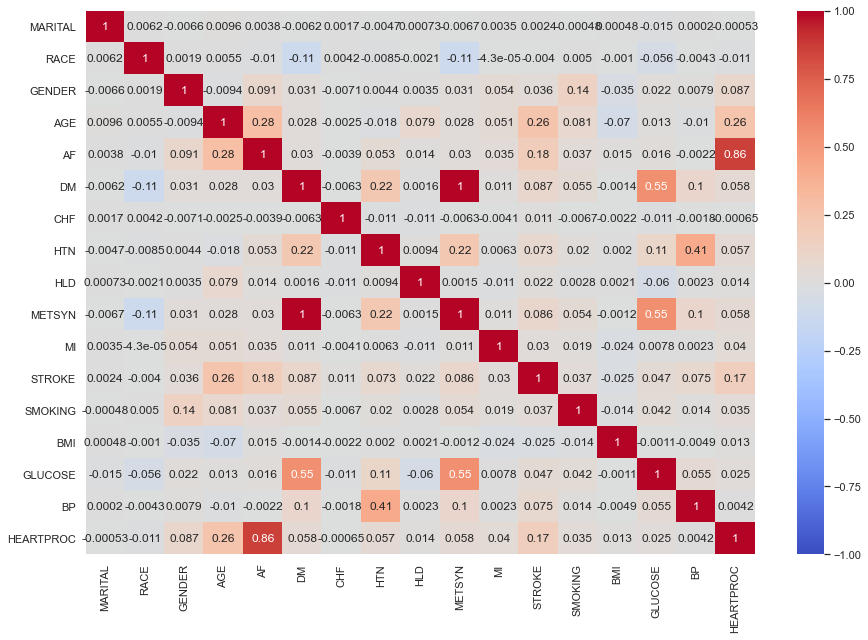

In [46]:
#Correlation
plt.figure(figsize=(15,10))
sns.heatmap(stroke_final_features.corr(), vmin=-1, cmap='coolwarm', annot=True);

### II.Histogram of all features

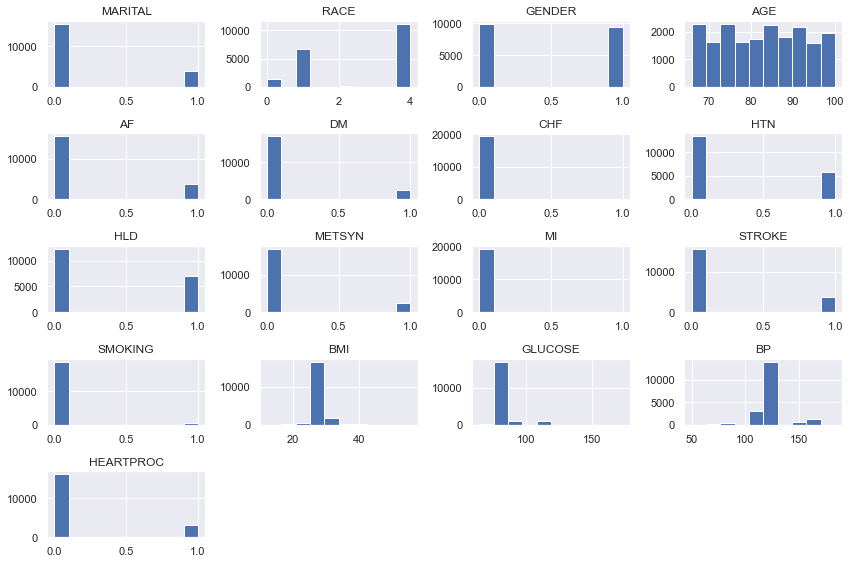

In [47]:
fig = stroke_final_features.hist(figsize=(12,8))
plt.tight_layout()
plt.show()

### 6. Develop models


### A. Prepare training and testing dataset

##### Drop the outcome ("stroke") column

In [48]:
stroke_features_only=stroke_final_features.drop(["STROKE"],axis =1)
stroke_features_only

,MARITAL,RACE,GENDER,AGE,AF,DM,CHF,HTN,HLD,METSYN,MI,SMOKING,BMI,GLUCOSE,BP,HEARTPROC
0,0,1,0,71,0,1,0,1,0,1,0,0,29.211111,78.544444,162.250000,0
1,0,4,0,82,1,0,0,1,1,0,0,0,27.800000,81.190000,124.625000,1
2,1,4,0,93,1,0,0,0,1,0,0,0,27.200000,80.060000,123.470588,1
3,0,1,1,68,1,0,0,0,1,0,0,0,29.472727,75.100000,120.000000,1
4,0,1,0,77,1,0,0,0,0,0,0,0,27.200000,80.300000,119.800000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19326,1,1,0,99,1,0,0,0,0,0,0,0,28.916667,85.700000,117.800000,1
19327,0,4,0,88,1,0,0,1,1,0,0,0,29.000000,83.060000,118.800000,1
19328,1,1,1,78,0,0,0,0,0,0,0,0,28.000000,82.783333,119.000000,0
19329,0,1,0,95,0,0,0,0,1,0,0,0,27.200000,83.630000,118.636364,0


##### Output "Stroke" only dataframe

In [49]:
stroke_only=stroke_final_features["STROKE"]
stroke_only

0        0
1        1
2        1
3        1
4        0
        ..
19326    0
19327    0
19328    0
19329    0
19330    1
Name: STROKE, Length: 19331, dtype: int32

### B. ML Model Training and Evaluation
We will implement and benchmark the performance of the following 3 ML algorithms:


1. Logistic Regression (LR)
2. Decision Tree (DT)
3. Random Forest (RF)


### Use pyspark for machine learning proces

In [50]:
#Convert pandas dataframe to spark dataframe
stroke_sparkdf=spark.createDataFrame(stroke_final_features)
stroke_sparkdf.printSchema()

root
 |-- MARITAL: long (nullable = true)
 |-- RACE: long (nullable = true)
 |-- GENDER: long (nullable = true)
 |-- AGE: long (nullable = true)
 |-- AF: long (nullable = true)
 |-- DM: long (nullable = true)
 |-- CHF: long (nullable = true)
 |-- HTN: long (nullable = true)
 |-- HLD: long (nullable = true)
 |-- METSYN: long (nullable = true)
 |-- MI: long (nullable = true)
 |-- STROKE: long (nullable = true)
 |-- SMOKING: long (nullable = true)
 |-- BMI: double (nullable = true)
 |-- GLUCOSE: double (nullable = true)
 |-- BP: double (nullable = true)
 |-- HEARTPROC: long (nullable = true)



###  Create a single column with all the features collated together using VectorAssembler

In [51]:
inputCols=[
        "MARITAL" ,
        "RACE",
        "GENDER",
        "AGE",
        "AF",
        "DM",
        "CHF",
        "HTN",
        "HLD",
        "METSYN",
        "MI",
        "SMOKING",
        "BMI",
        "GLUCOSE",
        "BP",
        "HEARTPROC"
      ]
outputCol ='features'
featuresCreator = ft.VectorAssembler (inputCols=inputCols, outputCol=outputCol)

stroke_train, stroke_test = stroke_sparkdf \
    .randomSplit([0.7, 0.3], seed=2017)

### Create test and training dataset for ML models

In [52]:
stroke_train, stroke_test = stroke_sparkdf  \
    .randomSplit([0.7, 0.3], seed=2017)

### 1. Random Forest classifier

#### Implement a random forest classifier 

In [88]:
import pyspark.sql.functions as func

stroke_sparkdf  = stroke_sparkdf.withColumn(
    'STROKE', 
    func.col('STROKE').cast(typ.DoubleType())
)

In [89]:
classifier = cl.RandomForestClassifier(
    numTrees=20, 
    maxDepth=5, 
    labelCol='STROKE')

rf_pipeline = Pipeline(
    stages=[
        featuresCreator, 
        classifier])

rf_model = rf_pipeline.fit(stroke_train)
rf_test = rf_model.transform(stroke_test)

####  Randomforest classifier performance

In [90]:
import pyspark.ml.evaluation as ev

evaluator = ev.BinaryClassificationEvaluator(
    rawPredictionCol='probability', 
    labelCol='STROKE')

print('AuROC for Randomforest classifier', evaluator.evaluate(rf_test, 
     {evaluator.metricName: 'areaUnderROC'}))
print('AuPR for Randomforest classifier', evaluator.evaluate(rf_test, {evaluator.metricName: 'areaUnderPR'}))

AuROC for Randomforest classifier 0.6973139502939092
AuPR for Randomforest classifier 0.3688635336464988


#### ROC curve metric for random forest classifier

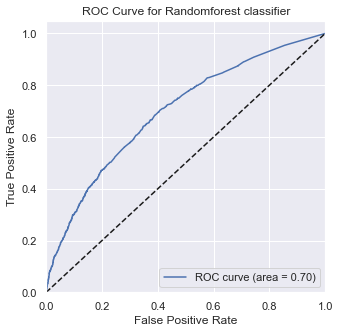

In [91]:
import sklearn.metrics as sk_me
rf_probArr = rf_test.select('probability','STROKE') \
                    .rdd \
                    .map( lambda row: [row[0][1], row[1]] ).collect()
rf_probArr = np.array(rf_probArr)

fpr, tpr, thresholds = sk_me.roc_curve( rf_probArr[:,1], rf_probArr[:,0], pos_label=1)
roc_auc = sk_me.auc(fpr, tpr)

plt.figure(figsize=(5,5))
plt.plot(fpr, tpr, label='ROC curve (area = {:0.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Randomforest classifier')
plt.legend(loc="lower right")
plt.show()

### 2. Logistic regression model

#### Create an estimator

In [93]:
logistic = cl.LogisticRegression(
    maxIter=10, 
    regParam=0.01, 
    labelCol='STROKE')


#### Create Logistic regression pipleline

In [94]:
logic_pipeline = Pipeline(stages=[
        featuresCreator, 
        logistic
    ])

#### Fit the model

In [95]:
logic_model = logic_pipeline.fit(stroke_train)
logic_test_model = logic_model.transform(stroke_test)

In [96]:
logic_test_model.take(1)

[Row(MARITAL=0, RACE=0, GENDER=0, AGE=67, AF=0, DM=0, CHF=0, HTN=0, HLD=0, METSYN=0, MI=0, STROKE=0, SMOKING=0, BMI=27.4, GLUCOSE=84.72251566731414, BP=118.0, HEARTPROC=0, features=SparseVector(16, {3: 67.0, 12: 27.4, 13: 84.7225, 14: 118.0}), rawPrediction=DenseVector([2.4256, -2.4256]), probability=DenseVector([0.9188, 0.0812]), prediction=0.0)]

#### Evaluate the Logistic Regression model

In [97]:
import pyspark.ml.evaluation as ev

evaluator = ev.BinaryClassificationEvaluator(
    rawPredictionCol='probability', 
    labelCol='STROKE')

print('AuROC for Logistic Regression Model', evaluator.evaluate(logic_test_model, 
     {evaluator.metricName: 'areaUnderROC'}))
print('AuPR for Logistic Regression Model', evaluator.evaluate(logic_test_model, {evaluator.metricName: 'areaUnderPR'}))

AuROC for Logistic Regression Model 0.6986892722240601
AuPR for Logistic Regression Model 0.36021082647096786


#### Prepare ROC curver for Logistic regression model

In [98]:
logic_probArr = logic_test_model.select('probability','STROKE') \
                    .rdd \
                    .map(  lambda row: [row[0][1], row[1]] ).collect()
logic_probArr = np.array(logic_probArr)
print( len(logic_probArr) )

5801


In [99]:
fpr1, tpr1, thresholds = sk_me.roc_curve( logic_probArr[:,1], logic_probArr[:,0], pos_label=1)
roc_auc1 = sk_me.auc(fpr1, tpr1)

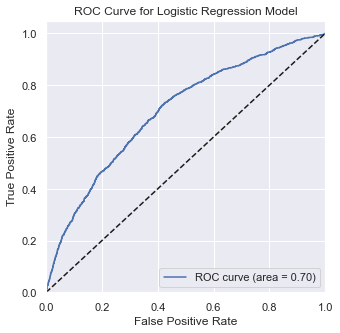

In [101]:
plt.figure(figsize=(5,5))
plt.plot(fpr1, tpr1, label='ROC curve (area = {:0.2f})'.format(roc_auc1))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Logistic Regression Model')
plt.legend(loc="lower right")
plt.show()

### 3. Decision tree model

#### Implement decision tree model and evaluate the model

In [102]:
classifier = cl.DecisionTreeClassifier(
    maxDepth=5, 
    labelCol='STROKE')
dt_pipeline = Pipeline(stages=[
        featuresCreator, 
        classifier]
)

dt_model = dt_pipeline.fit(stroke_train)
dt_test = dt_model.transform(stroke_test)

evaluator = ev.BinaryClassificationEvaluator(
    labelCol='STROKE')
print('AuROC for Decision Tree Model',evaluator.evaluate(dt_test, 
     {evaluator.metricName: "areaUnderROC"}))
print('AuPR for Decision Tree  Model',evaluator.evaluate(dt_test, 
     {evaluator.metricName: "areaUnderPR"}))

AuROC for Decision Tree Model 0.43066884654593446
AuPR for Decision Tree  Model 0.1929336853463901


#### Prepare ROC curve for decision model 

In [104]:
dt_probArr = dt_test.select('probability','STROKE') \
                    .rdd \
                    .map(  lambda row: [row[0][1], row[1]] ).collect()
dt_probArr = np.array(dt_probArr)
print( len(dt_probArr) )

5801


In [105]:
fpr2, tpr2, thresholds = sk_me.roc_curve( dt_probArr[:,1], dt_probArr[:,0], pos_label=1)
roc_auc2 = sk_me.auc(fpr2, tpr2)

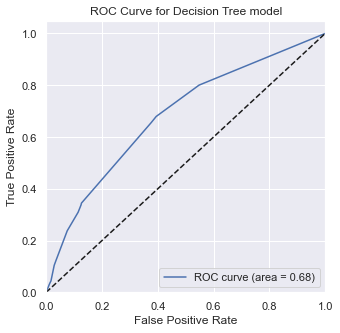

In [106]:
plt.figure(figsize=(5,5))
plt.plot(fpr2, tpr2, label='ROC curve (area = {:0.2f})'.format(roc_auc2))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Decision Tree model')
plt.legend(loc="lower right")
plt.show()